# Installing all the depedencies 

In [ ]:
!pip install pyspark
!pip install recommender-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=681b401d87e4780bbbce140a55a5bf9794341c5442f8a6103edb014424e4df54
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.7 MB/s eta 0:00:00


# Imports

In [ ]:
from google.colab import drive
import numpy as np

import os
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from reco_utils.common.spark_utils import start_or_get_spark
from reco_utils.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from reco_utils.tuning.parameter_sweep import generate_param_grid
from reco_utils.dataset.spark_splitters import spark_random_split

# Mount google drive

In [ ]:
drive.mount('/gdrive',force_remount=True)
%cd /gdrive/MyDrive/'COMPSCI 532'/Project/

DATA_PATH = './data/'
print('Data Files in Directory')
print(os.listdir(DATA_PATH))

Mounted at /gdrive
/gdrive/MyDrive/COMPSCI 532/Project
Data Files in Directory
['credits.csv', 'links.csv', 'movies_metadata.csv', 'keywords.csv', 'links_small.csv', 'ratings.csv', 'ratings_small.csv']


# Loading Data into Pyspark 

## start pyspark session

In [ ]:
sc = SparkContext('local')
spark = SparkSession(sc)

In [ ]:
data_schema = StructType([
    StructField('movieId', IntegerType(), False),
    StructField('imdbId', IntegerType(), False),
    StructField('tmdbId', IntegerType(), False)
])

links = spark.read.csv(
    DATA_PATH + 'links.csv', header=True, schema=data_schema
)
links.show(2)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
+-------+------+------+
only showing top 2 rows



In [ ]:
data_schema = StructType([
    StructField('userId', IntegerType(), False),
    StructField('movieId', IntegerType(), False),
    StructField('rating', FloatType(), False),
    StructField('timestamp', IntegerType(), False)
])

ratings = spark.read.csv(
    DATA_PATH + 'ratings.csv', header=True, schema=data_schema
)
ratings.show(2)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
+------+-------+------+----------+
only showing top 2 rows



In [ ]:
data_schema = StructType([
    StructField('title', StringType(), False),
    StructField('imdbId', IntegerType(), False),
    StructField('overview', StringType(), False)
])

metadata = spark.read.csv(
    'metadata.csv', header=True, schema=data_schema
)
metadata.show(2)

+---------+------+--------------------+
|    title|imdbId|            overview|
+---------+------+--------------------+
|Toy Story|114709|Led by Woody, And...|
|  Jumanji|113497|When siblings Jud...|
+---------+------+--------------------+
only showing top 2 rows



## Data-Preprocessing

Making the necesasry joins to get the data in the format we need

In [ ]:
movie_metadata = links.join(
    metadata,
    on = ["imdbId"],
    how='inner')
movie_metadata.show(5)

+------+-------+------+--------------------+--------------------+
|imdbId|movieId|tmdbId|               title|            overview|
+------+-------+------+--------------------+--------------------+
|114709|      1|   862|           Toy Story|Led by Woody, And...|
|113497|      2|  8844|             Jumanji|When siblings Jud...|
|113228|      3| 15602|    Grumpier Old Men|A family wedding ...|
|114885|      4| 31357|   Waiting to Exhale|"Cheated on, mist...|
|113041|      5| 11862|Father of the Bri...|Just when George ...|
+------+-------+------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
rating_data = ratings.join(
    movie_metadata,
    on = ["movieId"],
    how='inner')
rating_data.show(5)

+-------+------+------+----------+------+------+--------------------+--------------------+
|movieId|userId|rating| timestamp|imdbId|tmdbId|               title|            overview|
+-------+------+------+----------+------+------+--------------------+--------------------+
|     12|   140|   1.5|1456772795|112896| 12110|Dracula: Dead and...|When a lawyer sho...|
|     12|256019|   3.0| 859305957|112896| 12110|Dracula: Dead and...|When a lawyer sho...|
|     12|   196|   1.0| 849690840|112896| 12110|Dracula: Dead and...|When a lawyer sho...|
|     12|256078|   2.0| 838802198|112896| 12110|Dracula: Dead and...|When a lawyer sho...|
|     12|   229|   1.0|1037138476|112896| 12110|Dracula: Dead and...|When a lawyer sho...|
+-------+------+------+----------+------+------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
rating_data.select("movieId", "userId", "rating", "title", "overview").show(5)

+-------+------+------+---------+--------------------+
|movieId|userId|rating|    title|            overview|
+-------+------+------+---------+--------------------+
|      1|     8|   4.0|Toy Story|Led by Woody, And...|
|      1|155282|   4.0|Toy Story|Led by Woody, And...|
|      1|     9|   4.5|Toy Story|Led by Woody, And...|
|      1|155286|   3.5|Toy Story|Led by Woody, And...|
|      1|    12|   4.0|Toy Story|Led by Woody, And...|
+-------+------+------+---------+--------------------+
only showing top 5 rows



In [ ]:
rating_data = rating_data.drop('imdbId')
rating_data = rating_data.drop('tmdbId')
rating_data = rating_data.drop('timestamp')
rating_data.show(5)

+-------+------+------+---------+--------------------+
|movieId|userId|rating|    title|            overview|
+-------+------+------+---------+--------------------+
|      1|     8|   4.0|Toy Story|Led by Woody, And...|
|      1|155282|   4.0|Toy Story|Led by Woody, And...|
|      1|     9|   4.5|Toy Story|Led by Woody, And...|
|      1|155286|   3.5|Toy Story|Led by Woody, And...|
|      1|    12|   4.0|Toy Story|Led by Woody, And...|
+-------+------+------+---------+--------------------+
only showing top 5 rows



# Model Building

In [ ]:
COL_USER = "userId"
COL_ITEM = "movieId"
COL_RATING = "rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "timestamp"

schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

## Small dataset

In [ ]:
ratings_small = spark.read.csv(
    DATA_PATH + 'ratings_small.csv', header=True, schema= schema
).cache()

In [ ]:
dfs_train, dfs_test = spark_random_split(ratings_small, ratio=0.75, seed=42)

### Hyperparameter tuning

In [ ]:
param_dict = {
    "rank": [5, 10, 15],
    "regParam": [0.01, 0.1, 1.0],
    "maxIter": [5, 10, 15]
}
param_grid = generate_param_grid(param_dict)

In [ ]:
from tqdm.notebook import tqdm
rmse = []
mae = []
r2 = []
exp_var = []

for g in tqdm(param_grid):
    print(g)
    als = ALS(        
        userCol=COL_USER, 
        itemCol=COL_ITEM, 
        ratingCol=COL_RATING, 
        coldStartStrategy="drop",
        **g
    )
    
    model = als.fit(dfs_train)
    
    dfs_pred = model.transform(dfs_test).drop(COL_RATING)
    
    del model
    
    evaluations = SparkRatingEvaluation(
        dfs_test, 
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
        )
    rmse.append(evaluations.rmse())
    mae.append(evaluations.mae())
    r2.append(evaluations.rsquared())
    exp_var.append(evaluations.exp_var())

    del evaluations

In [ ]:
np.array(param_grid)[np.argsort(rmse)]

array([{'maxIter': 15, 'rank': 5, 'regParam': 0.1},
       {'maxIter': 10, 'rank': 5, 'regParam': 0.1},
       {'maxIter': 5, 'rank': 5, 'regParam': 0.1},
       {'maxIter': 15, 'rank': 10, 'regParam': 0.1},
       {'maxIter': 15, 'rank': 15, 'regParam': 0.1},
       {'maxIter': 10, 'rank': 15, 'regParam': 0.1},
       {'maxIter': 10, 'rank': 10, 'regParam': 0.1},
       {'maxIter': 5, 'rank': 10, 'regParam': 0.1},
       {'maxIter': 5, 'rank': 15, 'regParam': 0.1},
       {'maxIter': 5, 'rank': 5, 'regParam': 0.01},
       {'maxIter': 10, 'rank': 5, 'regParam': 0.01},
       {'maxIter': 15, 'rank': 5, 'regParam': 0.01},
       {'maxIter': 5, 'rank': 10, 'regParam': 0.01},
       {'maxIter': 10, 'rank': 10, 'regParam': 0.01},
       {'maxIter': 15, 'rank': 10, 'regParam': 0.01},
       {'maxIter': 5, 'rank': 15, 'regParam': 0.01},
       {'maxIter': 10, 'rank': 15, 'regParam': 0.01},
       {'maxIter': 15, 'rank': 15, 'regParam': 0.01},
       {'maxIter': 15, 'rank': 15, 'regParam': 1.

In [ ]:
x,y,z1,z2 = [],[],[],[]
for i, params in enumerate(param_grid):
    if params['regParam'] != 0.1:
        continue
    x.append(params['rank'])
    y.append(params['maxIter'])
    z1.append(rmse[i])
    z2.append(mae[i])

In [ ]:
print(z1, x, y, sep='\n')

[0.9146743959222041, 0.9210782103717268, 0.9212677064141868, 0.9135059228394801, 0.9207462193936166, 0.9202002284378153, 0.9126857647906066, 0.9185996091386854, 0.9196993139518302]
[5, 10, 15, 5, 10, 15, 5, 10, 15]
[5, 5, 5, 10, 10, 10, 15, 15, 15]


In [ ]:
z1 = np.reshape(z1, (3,3))
z2 = np.reshape(z2, (3,3))
z1df = pd.DataFrame(data=z1, index=pd.Index(param_dict["maxIter"], name="maxIter"), columns=pd.Index(param_dict["rank"], name="rank"))
z2df = pd.DataFrame(data=z2, index=pd.Index(param_dict["maxIter"], name="maxIter"), columns=pd.Index(param_dict["rank"], name="rank"))

<Axes: xlabel='rank', ylabel='maxIter'>

Text(0.5, 1.0, 'RMSE variation with hyperparameters and regularization = 0.1')

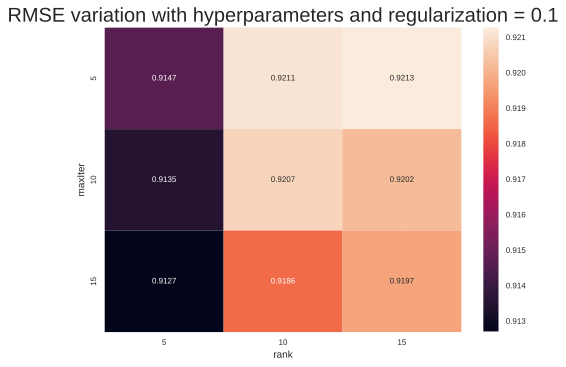

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(z1df, cbar=True, annot=True, fmt=".4g")
plt.title("RMSE variation with hyperparameters and regularization = 0.1", fontsize=20)
plt.show()

<Axes: xlabel='rank', ylabel='maxIter'>

Text(0.5, 1.0, 'MAE variation with hyperparameters and regularization = 0.1')

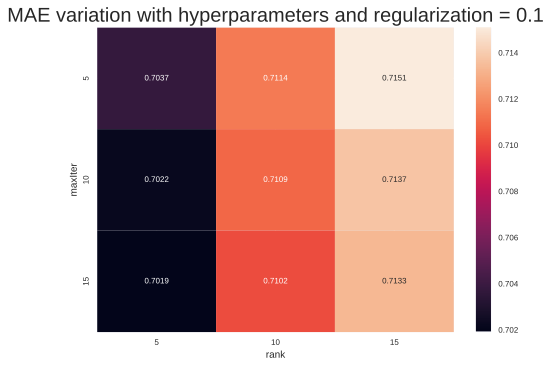

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(z2df, cbar=True, annot=True, fmt=".4g")
plt.title("MAE variation with hyperparameters and regularization = 0.1", fontsize=20)
plt.show()

### Training on best hyperparameters

In [ ]:
g = {'maxIter': 15, 'rank': 5, 'regParam': 0.1}
als = ALS(
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    coldStartStrategy="drop",
    **g
    )
    
model = als.fit(dfs_train)
model.write().save("saved_model_small")

### Prediction and evaluation of model

In [ ]:
import time

In [ ]:
dfs_pred = model.transform(dfs_test)
start_time = time.time()
evaluations = SparkRatingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)
print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)
print(f"elapsed time: {time.time() - start_time}")

start_time = time.time()
evaluations = SparkRankingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=10
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)
print(f"elapsed time: {time.time() - start_time}")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE score = 0.9148799995244534
MAE score = 0.7035154000132601
R2 score = 0.24288248270185042
Explained variance score = 0.26454987130028695
elapsed time: 15.769513607025146
Precision@k = 0.8904619970193739
Recall@k = 0.5770147187816198
NDCG@k = 0.998135812319825
Mean average precision = 0.5770147187816198
elapsed time: 8.135977029800415


### Analyze for one userId

In [ ]:
dfs_pred.groupBy("userId").count().orderBy("count", ascending=False).show(3)

+------+-----+
|userId|count|
+------+-----+
|   564|  438|
|   547|  404|
|    15|  400|
+------+-----+
only showing top 3 rows



Get best and worst predictions for userId 564

In [ ]:
from pyspark.sql.functions import abs
df_user = dfs_pred.where("userID == 564").withColumn('prediction error', abs(dfs_pred['rating'] - dfs_pred['prediction']))
df_user.orderBy('prediction error', ascending=True).show(), df_user.orderBy('prediction error', ascending=False).show()

+------+-------+------+---------+----------+----------------+
|userId|movieId|rating|timestamp|prediction|prediction error|
+------+-------+------+---------+----------+----------------+
|   564|   1973|   2.0|974709294| 1.9974314|    0.0025686026|
|   564|   2297|   2.0|974843206| 1.9957771|      0.00422287|
|   564|   2580|   4.0|974711243|  4.008902|     0.008902073|
|   564|   3060|   4.0|974833079| 4.0111666|     0.011166573|
|   564|   1186|   5.0|974712764| 5.0126963|     0.012696266|
|   564|   2583|   4.0|974843921| 3.9835124|     0.016487598|
|   564|    252|   3.0|974837728| 2.9714384|     0.028561592|
|   564|     89|   3.0|974715602| 3.0359664|     0.035966396|
|   564|   1367|   3.0|974837509| 3.0395436|      0.03954363|
|   564|    942|   4.0|974843691| 3.9577637|     0.042236328|
|   564|   1016|   4.0|974837386|  3.956483|     0.043517113|
|   564|   2950|   3.0|974843416| 2.9550674|     0.044932604|
|   564|   2076|   4.0|974711893|  4.044958|     0.044958115|
|   564|

(None, None)

In [ ]:
user_recommendations = model.recommendForUserSubset(dfs_test.where('userId == 564'), 20)
print(user_recommendations.select('recommendations').first())

Row(recommendations=[Row(movieId=83411, rating=6.166429042816162), Row(movieId=83359, rating=6.166429042816162), Row(movieId=83318, rating=6.166429042816162), Row(movieId=67504, rating=6.166429042816162), Row(movieId=5047, rating=6.015446186065674), Row(movieId=71033, rating=5.978158950805664), Row(movieId=26084, rating=5.700839042663574), Row(movieId=26131, rating=5.588240146636963), Row(movieId=4396, rating=5.579128265380859), Row(movieId=80599, rating=5.549786567687988), Row(movieId=72647, rating=5.549786567687988), Row(movieId=26400, rating=5.549786567687988), Row(movieId=25764, rating=5.549786567687988), Row(movieId=8797, rating=5.549786567687988), Row(movieId=5914, rating=5.549786567687988), Row(movieId=4405, rating=5.549786567687988), Row(movieId=665, rating=5.527074337005615), Row(movieId=5490, rating=5.476734638214111), Row(movieId=8511, rating=5.473506927490234), Row(movieId=26171, rating=5.395317554473877)])


Check if top predictions are present in the dataset and what ratings those movies got

In [ ]:
list1 = [83411, 83359, 83318, 67504, 26131, 6791, 1859, 2810, 26840, 190, 5490, 363, 4965, 3153, 3672, 54372, 803, 2836, 80599, 72647]
import pyspark.sql.functions as F
ratings_small.where('userId == 564').where(F.col('movieId').isin(list1)).show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|   564|    363|   5.0|974840424|
|   564|   3153|   5.0|974838858|
|   564|   3672|   5.0|974839862|
+------+-------+------+---------+



## Full DataSet. 

### Training on best hyperparameters identified on small dataset

In [ ]:
dfs_train, dfs_test = spark_random_split(ratings, ratio=0.75, seed=42)

In [ ]:
import time

In [ ]:
g = {'maxIter': 15, 'rank': 5, 'regParam': 0.1}
als = ALS(
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    coldStartStrategy="drop",
    **g
    )

start_time = time.time()
model = als.fit(dfs_train)
print(f"elapsed time: {time.time() - start_time}")
model.write().save("saved_model_large")

elapsed time: 303.9111773967743


In [ ]:
model = ALSModel.load("saved_model_large")

### Prediction and evaluation of model

In [ ]:
dfs_pred = model.transform(dfs_test)
dfs_pred.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|    858|   5.0|1425941523|   4.70527|
|     1|   2762|   4.5|1425941300|  4.328716|
|     1|   2959|   4.0|1425941601|  4.714684|
|     1|   4226|   4.0|1425942228| 4.7000313|
|     1|  54503|   3.5|1425941313| 4.2712216|
|     1|  81834|   5.0|1425942133| 3.7667215|
|     1|  96821|   5.0|1425941382| 4.5377226|
|     2|     32|   2.0| 867039166| 3.4027534|
|     2|     58|   3.0| 867039325|  3.660709|
|     2|     79|   4.0| 867039325|  3.241688|
|     2|    260|   4.0| 867039249| 3.3417816|
|     2|    339|   5.0| 867041296| 3.3993149|
|     2|    786|   1.0| 867039249| 2.9584153|
|     2|   1233|   4.0| 867039820| 3.4589393|
|     2|   1356|   5.0| 867039288| 3.2055817|
|     2|   1475|   3.0| 867040824| 3.2037232|
|     3|    480|   3.0|1048076925| 2.7132936|
|     3|    527|   4.0|1048076900| 3.5945258|
|     3|   1270|   3.0|1048076976|

In [ ]:
start_time = time.time()
evaluations = SparkRatingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)
print(
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)
print(f"elapsed time: {time.time() - start_time}")

start_time = time.time()
evaluations = SparkRankingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION,
    k=10
)

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)
print(f"elapsed time: {time.time() - start_time}")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE score = 0.8246497236836979
MAE score = 0.6357202126161584
R2 score = 0.4006366035842652
Explained variance score = 0.4083181849506766
elapsed time: 401.04404187202454
Precision@k = 0.6967805018950819
Recall@k = 0.7317379640696817
NDCG@k = 0.9999628116555445
Mean average precision = 0.7317379640696817
elapsed time: 229.0645670890808


### Analyze for one userId

In [ ]:
start_time = time.time()
ratings_full.groupBy("userId").count().orderBy("count", ascending=False).show(3)
print(f"elapsed time: {time.time() - start_time}")

+------+-----+
|userId|count|
+------+-----+
| 45811|18276|
|  8659| 9279|
|270123| 7638|
+------+-----+
only showing top 3 rows

elapsed time: 6.305262327194214


In [ ]:
from pyspark.sql.functions import abs
df_user = dfs_pred.where("userID == 45811").withColumn('prediction error', abs(dfs_pred['rating'] - dfs_pred['prediction']))
df_user.show()
df_user.orderBy('prediction error', ascending=True).show(5), df_user.orderBy('prediction error', ascending=False).show(5)

+------+-------+------+----------+----------+----------------+
|userId|movieId|rating| timestamp|prediction|prediction error|
+------+-------+------+----------+----------+----------------+
| 45811|    496|   4.5|1455488796| 3.2251909|       1.2748091|
| 45811|   2122|   2.5|1482568531| 2.0998292|       0.4001708|
| 45811|   2366|   4.0|1450166181| 3.5820484|      0.41795158|
| 45811|   3749|   3.0|1455271853|  3.236781|      0.23678088|
| 45811|   4519|   3.5|1473241811| 3.1013837|       0.3986163|
| 45811|   4935|   4.0|1455271838| 3.3281066|      0.67189336|
| 45811|   5518|   4.0|1455488805| 3.7766316|       0.2233684|
| 45811|   6658|   3.0|1450162893|  2.725479|       0.2745211|
| 45811|   7880|   3.5|1455488841| 3.1979845|      0.30201554|
| 45811|   7982|   3.5|1450164159| 3.3696973|      0.13030267|
| 45811|  40574|   0.5|1455399790| 2.1914778|       1.6914778|
| 45811|  44022|   3.0|1450166640| 2.7193031|      0.28069687|
| 45811|  47084|   4.0|1455271832| 3.6060095|      0.39

(None, None)

In [ ]:
user_recommendations = model.recommendForUserSubset(dfs_test.where('userId == 45811'), 20)
user_recommendations.select('recommendations').first()

Row(recommendations=[Row(movieId=173939, rating=5.7616658210754395), Row(movieId=164937, rating=5.571941375732422), Row(movieId=174665, rating=5.147409915924072), Row(movieId=158832, rating=5.020513534545898), Row(movieId=133881, rating=4.963062286376953), Row(movieId=135735, rating=4.873232364654541), Row(movieId=175275, rating=4.862626552581787), Row(movieId=148836, rating=4.862626552581787), Row(movieId=148791, rating=4.862626552581787), Row(movieId=141858, rating=4.862626552581787), Row(movieId=141301, rating=4.862626552581787), Row(movieId=112064, rating=4.862626552581787), Row(movieId=90199, rating=4.862626552581787), Row(movieId=169852, rating=4.8392109870910645), Row(movieId=175335, rating=4.815463066101074), Row(movieId=86237, rating=4.808316230773926), Row(movieId=159467, rating=4.795290470123291), Row(movieId=127843, rating=4.791383266448975), Row(movieId=155619, rating=4.7722063064575195), Row(movieId=143641, rating=4.766750812530518)])

check if top 20 recommendations are present in the ratings dataset

In [ ]:
list1 = [173939, 164937, 174665, 169852, 155090, 101862, 175335, 158832, 175275, 148836, 148791, 141858, 141301, 112064, 90199, 155619, 133881, 151989, 66389, 159467]

In [ ]:
import pyspark.sql.functions as F
ratings_full.where('userId == 45811').where(F.col('movieId').isin(list1)).show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
| 45811|  90199|   5.0|1455274835|
| 45811| 112064|   5.0|1479221010|
| 45811| 141301|   5.0|1465648876|
| 45811| 141858|   5.0|1497376303|
| 45811| 148791|   5.0|1455577738|
| 45811| 148836|   5.0|1455251737|
| 45811| 155090|   3.0|1482568528|
| 45811| 158832|   3.5|1479221012|
| 45811| 159467|   5.0|1466175142|
| 45811| 175275|   5.0|1500754522|
+------+-------+------+----------+



### Analyze recommendations made for user

In [ ]:
list2 = [173939, 164937, 174665, 169852, 101862, 175335, 155619, 133881, 151989, 66389, 159467]
list3 = [155090, 90199]

In [ ]:
movie1 = movie_metadata.filter(movie_metadata.movieId.isin(list2))
movie1.select('overview').show()

+--------------------+
|            overview|
+--------------------+
|Summer in L.A., i...|
|In the spring of ...|
|"The story of Ben...|
|In her film debut...|
|"Frank Lehmann, 2...|
|Bahman Mohassess ...|
|30-year old Kertu...|
|                null|
|Two introverted p...|
|Emily Walters is ...|
+--------------------+



good prediction

In [ ]:
movie1 = movie_metadata.filter(movie_metadata.movieId == 90199)
movie1.select('overview').first()

Row(overview='Taraneh is a model 15-year-old Iranian girl, studious and filial, who supports her ailing grandmother with a job at a photo shop and visits her father (who has been imprisoned for reasons never made clear in the film) bearing gifts of cigarettes and magazines. But when Amir, a young man from a well-off family, sets his sights on Taraneh and courts her with an intensity that borders on stalking, her well-ordered life spirals into chaos.')

misprediction

In [ ]:
movie1 = movie_metadata.filter(movie_metadata.movieId == 155090)
movie1.select('overview').first()

Row(overview='Roja lives in a Tamil village, and her sister is about to marry a man from the city, who decides to marry Roja instead and gets a job assignment in Kashmir, where some militants decide to kidnap them.')

unknown prediction

In [ ]:
movie1 = movie_metadata.filter(movie_metadata.movieId == 164937)
movie1.select('overview').first()

Row(overview="30-year old Kertu has lived under her father's power her whole life. Because of her gentle nature, she is thought by locals to be a little simple-minded. The young woman makes her first timid attempt to change something in her life - she send a postcard to Villu, a handsome but degenerate village drunk.")

# Prediction pipeline

In [ ]:
import pandas as pd

In [ ]:
# data = [564]
data = input()
a = pd.DataFrame(data, columns=['userId'])
sparkDF=spark.createDataFrame(a)
sparkDF.show()

+------+
|userId|
+------+
|   564|
+------+



In [ ]:
a = model.recommendForUserSubset(sparkDF, 10)
a.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   564|[{151989, 6.82406...|
+------+--------------------+



In [ ]:
a.first()

Row(userId=564, recommendations=[Row(movieId=151989, rating=6.824061393737793), Row(movieId=159761, rating=5.830824375152588), Row(movieId=144202, rating=5.683992385864258), Row(movieId=163126, rating=5.612621307373047), Row(movieId=107434, rating=5.593628406524658), Row(movieId=107252, rating=5.593628406524658), Row(movieId=110097, rating=5.585602760314941), Row(movieId=164937, rating=5.565644264221191), Row(movieId=114687, rating=5.496051788330078), Row(movieId=150228, rating=5.477571964263916)])